In [1]:
%pip install tensorflow

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import RMSprop
from sklearn.model_selection import train_test_split
from sklearn import preprocessing

2025-10-16 20:27:53.171220: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-10-16 20:27:53.201002: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
train_df = pd.read_csv('USCensusTraining.csv')

In [4]:
train_df.isnull().sum().sort_values(ascending=False) # No missing value

age               0
workclass         0
demogweight       0
education         0
education-num     0
marital-status    0
occupation        0
relationship      0
race              0
sex               0
capital-gain      0
capital-loss      0
hours-per-week    0
native-country    0
income            0
dtype: int64

In [5]:
# Drop redundant attribute 'education'
train_df = train_df.drop(columns=['education'])

In [6]:
X = train_df.drop(columns=['income'])
pd.DataFrame(X).describe()

,age,demogweight,education-num,capital-gain,capital-loss,hours-per-week
count,25000.000000,2.500000e+04,25000.000000,25000.000000,25000.00000,25000.000000
mean,38.606920,1.897418e+05,10.081440,1088.579040,86.49992,40.407440
std,13.687769,1.052947e+05,2.557035,7486.621197,401.25358,12.299267
min,17.000000,1.228500e+04,1.000000,0.000000,0.00000,1.000000
25%,28.000000,1.179630e+05,9.000000,0.000000,0.00000,40.000000
50%,37.000000,1.783530e+05,10.000000,0.000000,0.00000,40.000000
75%,48.000000,2.368610e+05,12.000000,0.000000,0.00000,45.000000
max,90.000000,1.484705e+06,16.000000,99999.000000,4356.00000,99.000000


In [7]:
train_df['income'] = train_df['income'].str.replace('K', '', regex=False)
train_df['income'] = train_df['income'].str.replace('.', '', regex=False)
train_df['income'] = train_df['income'].str.strip()
y = train_df['income'].apply(lambda x: 1 if x == '>50' else 0)

In [8]:
pd.DataFrame(y).describe()

,income
count,25000.000000
mean,0.239360
std,0.426701
min,0.000000
25%,0.000000
50%,0.000000
75%,0.000000
max,1.000000


In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, stratify = y, random_state = 42)

In [10]:
# One-hot encode categorical variables
categorical_cols = ['workclass', 'marital-status', 'occupation', 'relationship', 'race', 'sex', 'native-country']
X_train = pd.get_dummies(X_train, columns=categorical_cols)
X_test_original = X_test.copy()
X_test = pd.get_dummies(X_test, columns=categorical_cols)

In [11]:
X_test = X_test.reindex(columns=X_train.columns, fill_value=0)

In [12]:
(X_train.columns == X_test.columns).all() 

np.True_

In [13]:
# Scale continuous variables
continuous_cols = ['age', 'demogweight', 'education-num', 'capital-gain', 'capital-loss', 'hours-per-week']
scaler = preprocessing.MinMaxScaler().fit(X_train[continuous_cols])
X_train[continuous_cols] = scaler.transform(X_train[continuous_cols])
X_test[continuous_cols] = scaler.transform(X_test[continuous_cols])

In [14]:
X_train.head()

,age,demogweight,education-num,capital-gain,capital-loss,hours-per-week,workclass_?,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native-country_Portugal,native-country_Puerto-Rico,native-country_Scotland,native-country_South,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia
11490,0.136986,0.139837,0.600000,0.0,0.000000,0.397959,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
10633,0.205479,0.230630,0.600000,0.0,0.340909,0.448980,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
853,0.123288,0.057173,0.800000,0.0,0.000000,0.397959,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False
2847,0.123288,0.119571,0.533333,0.0,0.000000,0.397959,True,False,False,False,...,False,False,False,False,False,False,False,True,False,False
15816,0.246575,0.073150,0.733333,0.0,0.000000,0.448980,False,False,False,False,...,False,False,False,False,False,False,False,True,False,False


In [15]:
tf.random.set_seed(42)
model = Sequential(name = "ANN")
model.add(Input(shape = (X_train.shape[1], )))
model.add(Dense(32, activation = 'sigmoid', kernel_initializer = 'glorot_uniform', name = 'hidden'))
model.add(Dense(1, activation = 'sigmoid', name = 'output'))
model.compile(optimizer = RMSprop(learning_rate = 1e-3),
              loss = 'binary_crossentropy',
              metrics = ['accuracy'])

In [16]:
history = model.fit(X_train, y_train, epochs = 40, batch_size = 32, validation_split = 0.2, verbose = 2)

Epoch 1/40
500/500 - 1s - 2ms/step - accuracy: 0.7871 - loss: 0.4354 - val_accuracy: 0.8175 - val_loss: 0.3894
Epoch 2/40
500/500 - 1s - 1ms/step - accuracy: 0.8261 - loss: 0.3759 - val_accuracy: 0.8263 - val_loss: 0.3710
Epoch 3/40
500/500 - 1s - 1ms/step - accuracy: 0.8316 - loss: 0.3628 - val_accuracy: 0.8295 - val_loss: 0.3640
Epoch 4/40
500/500 - 1s - 1ms/step - accuracy: 0.8338 - loss: 0.3563 - val_accuracy: 0.8310 - val_loss: 0.3595
Epoch 5/40
500/500 - 1s - 1ms/step - accuracy: 0.8351 - loss: 0.3516 - val_accuracy: 0.8332 - val_loss: 0.3558
Epoch 6/40
500/500 - 1s - 1ms/step - accuracy: 0.8365 - loss: 0.3478 - val_accuracy: 0.8335 - val_loss: 0.3526
Epoch 7/40
500/500 - 1s - 1ms/step - accuracy: 0.8393 - loss: 0.3446 - val_accuracy: 0.8355 - val_loss: 0.3498
Epoch 8/40
500/500 - 1s - 1ms/step - accuracy: 0.8404 - loss: 0.3418 - val_accuracy: 0.8350 - val_loss: 0.3473
Epoch 9/40
500/500 - 1s - 1ms/step - accuracy: 0.8416 - loss: 0.3393 - val_accuracy: 0.8365 - val_loss: 0.3451
E

In [17]:
loss, acc = model.evaluate(X_test, y_test, verbose = 2)
print(f"Test accuracy: {acc: .3f}")

157/157 - 0s - 2ms/step - accuracy: 0.8526 - loss: 0.3192
Test accuracy:  0.853


### b. Most Important Variables for Predicting Income

In [18]:
X_mean = X_test.mean().to_numpy().reshape(1, -1)
X_min = X_test.min().to_numpy()
X_max = X_test.max().to_numpy()

In [19]:
output_mean = model.predict(X_mean)
output_mean = np.array(output_mean).flatten()

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


In [20]:
results = []
for i, col in enumerate(X_test.columns):
    x_low = X_mean.copy()
    x_high = X_mean.copy()

    x_low[0, i] = X_min[i]
    x_high[0, i] = X_max[i]

    y_low = np.array(model.predict(x_low)).flatten()
    y_high = np.array(model.predict(x_high)).flatten()

    change_low = np.abs(y_low - output_mean)
    change_high = np.abs(y_high - output_mean)

    mean_change = np.mean([change_low, change_high])

    results.append({
        'Feature': col,
        'Mean Change (Sensitivity)': mean_change
    })

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
1/1 ━━━━━━━━

In [21]:
importance_df = pd.DataFrame(results).sort_values(
    'Mean Change (Sensitivity)', ascending=False
)

print(importance_df)

                              Feature  Mean Change (Sensitivity)
3                        capital-gain                   0.459719
5                      hours-per-week                   0.191934
2                       education-num                   0.178182
0                                 age                   0.159081
4                        capital-loss                   0.127324
..                                ...                        ...
80         native-country_Philippines                   0.001535
11             workclass_Self-emp-inc                   0.001193
14              workclass_Without-pay                   0.000000
68             native-country_Hungary                   0.000000
65  native-country_Holand-Netherlands                   0.000000

[92 rows x 2 columns]


In [22]:
importance_df['Original Feature'] = importance_df['Feature'].str.split('_').str[0]
importance_cat = (importance_df
                  .groupby('Original Feature')['Mean Change (Sensitivity)']
                  .mean()   # or .sum() if you prefer
                  .reset_index()
                  .sort_values('Mean Change (Sensitivity)', ascending=False))

print(importance_cat)

   Original Feature  Mean Change (Sensitivity)
1      capital-gain                   0.459719
5    hours-per-week                   0.191934
4     education-num                   0.178182
0               age                   0.159081
2      capital-loss                   0.127324
6    marital-status                   0.052855
10     relationship                   0.046050
8        occupation                   0.044303
3       demogweight                   0.031655
7    native-country                   0.025726
9              race                   0.025099
11              sex                   0.019159
12        workclass                   0.012658


Capital gain is the most important variables for predicting income since the greater the change in the output, the more important that feature is. 

### c. Explain the Predicted Accuracy

The neural network correctly predicted whether income >50K or ≤50K for ~85.3% of the test data.

### d. Compare the predicted income with actual income. Which error is the model more prone to making? Is this type of error more protective of, say, banks or loan applicants?

In [23]:
from sklearn.metrics import confusion_matrix

y_pred = (model.predict(X_test) > 0.5).astype(int)

from sklearn.metrics import classification_report
print(classification_report(y_test, y_pred, digits = 3))

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step
              precision    recall  f1-score   support

           0      0.887     0.925     0.905      3803
           1      0.722     0.624     0.670      1197

    accuracy                          0.853      5000
   macro avg      0.804     0.774     0.787      5000
weighted avg      0.847     0.853     0.849      5000



The recall (true positive rate) for class 1 (high income) is relatively low, indicating the model fails to correctly identify a substantial portion of high-income individuals. Many actual high-income people are misclassified as low-income.
This type of error more protective for banks.

### e. Which occupations are associated with predicted income over $50,000?
### Which education levels? Which ages? Is this intuitive?

In [24]:
y_pred = (model.predict(X_test) > 0.5).astype(int)
X_test_original['predicted_income'] = y_pred
high_income = X_test_original[X_test_original['predicted_income'] == 1]
occupation_counts = high_income['occupation'].value_counts()
print("Top occupations predicted >50K:\n", occupation_counts.head(10))

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 559us/step
Top occupations predicted >50K:
 occupation
Exec-managerial      332
Prof-specialty       307
Sales                146
Craft-repair          79
Adm-clerical          58
Tech-support          34
Protective-serv       32
Transport-moving      19
?                     10
Machine-op-inspct      8
Name: count, dtype: int64


In [25]:
education_counts = high_income['education-num'].value_counts()
print("\nTop education levels predicted >50K:\n", education_counts.head(10))


Top education levels predicted >50K:
 education-num
13    379
10    159
14    148
9     129
15     86
16     44
11     43
12     39
6       3
5       1
Name: count, dtype: int64


In [26]:
mean_age = high_income['age'].mean()
median_age = high_income['age'].median()
print(f"\nMean age for predicted >50K: {mean_age:.1f}")
print(f"Median age for predicted >50K: {median_age:.1f}")


Mean age for predicted >50K: 45.4
Median age for predicted >50K: 44.0


Exec-managerial and Prof-specialty are associated with predicted income over 50,000. 
Education level that is 13 yrs is associated with predicted income over 50,000. 
Age around 44-45 is associated with predicted income over 50,000. 

### Construct graphs of the top three categorical predictors, and their relationship to predicted income

In [28]:
import matplotlib.pyplot as plt
import seaborn as sns

/tmp/ipykernel_3752/1416993291.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature, y='predicted_income', data=prop_df, ax=axes[i], palette='viridis')
/tmp/ipykernel_3752/1416993291.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature, y='predicted_income', data=prop_df, ax=axes[i], palette='viridis')
/tmp/ipykernel_3752/1416993291.py:12: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature, y='predicted_income', data=prop_df, ax=axes[i], palette='viridis')


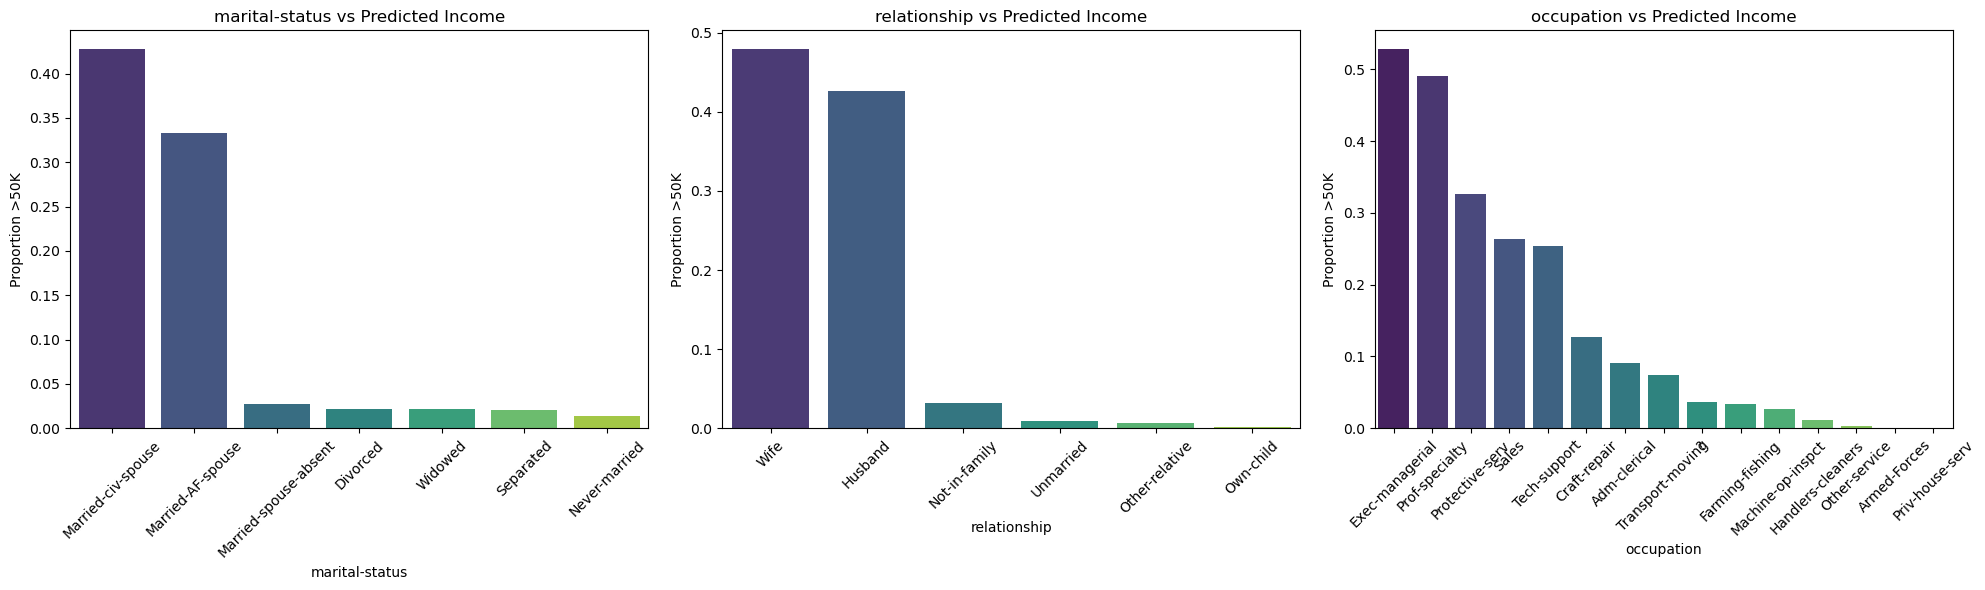

In [29]:
top_categorical = ['marital-status', 'relationship', 'occupation']
fig, axes = plt.subplots(1, 3, figsize=(20,6))

for i, feature in enumerate(top_categorical):

    prop_df = (X_test_original
               .groupby(feature)['predicted_income']
               .mean()
               .sort_values(ascending=False)
               .reset_index())
    
    sns.barplot(x=feature, y='predicted_income', data=prop_df, ax=axes[i], palette='viridis')
    
    axes[i].set_ylabel('Proportion >50K')
    axes[i].set_xlabel(feature)
    axes[i].set_title(f'{feature} vs Predicted Income')
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()


### f. Construct a histogram of one numeric variable which is important in the model, with an overlay of income

In [35]:
X_test_original['capital-gain'].describe()

count     5000.000000
mean       963.876600
std       6594.502258
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      99999.000000
Name: capital-gain, dtype: float64

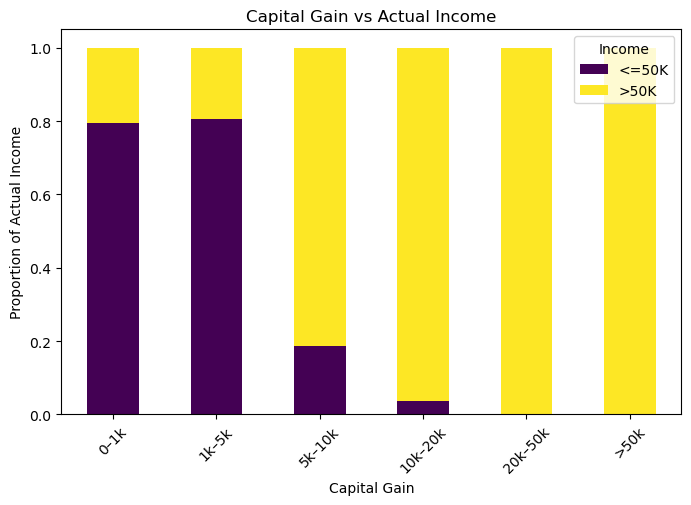

In [32]:
X_test_original['actual_income'] = y_test.values
bins = [0, 1000, 5000, 10000, 20000, 50000, X_test_original['capital-gain'].max()]
labels = ['0–1k', '1k–5k', '5k–10k', '10k–20k', '20k–50k', '>50k']
X_test_original['capital_gain_bin'] = pd.cut(
    X_test_original['capital-gain'], bins=bins, labels=labels, include_lowest=True
)

capital_crosstab = pd.crosstab(
    X_test_original['capital_gain_bin'],
    X_test_original['actual_income'],
    normalize='index'
)

capital_crosstab.plot(
    kind='bar',
    stacked=True,
    figsize=(8,5),
    colormap='viridis'
)
plt.ylabel('Proportion of Actual Income')
plt.xlabel('Capital Gain')
plt.title('Capital Gain vs Actual Income')
plt.legend(title='Income', labels=['<=50K', '>50K'])
plt.xticks(rotation=45)
plt.show()

In [126]:
X_test_original['demogweight'].describe()

count    5.000000e+03
mean     1.903366e+05
std      1.066932e+05
min      1.882700e+04
25%      1.177262e+05
50%      1.780835e+05
75%      2.390055e+05
max      1.366120e+06
Name: demogweight, dtype: float64

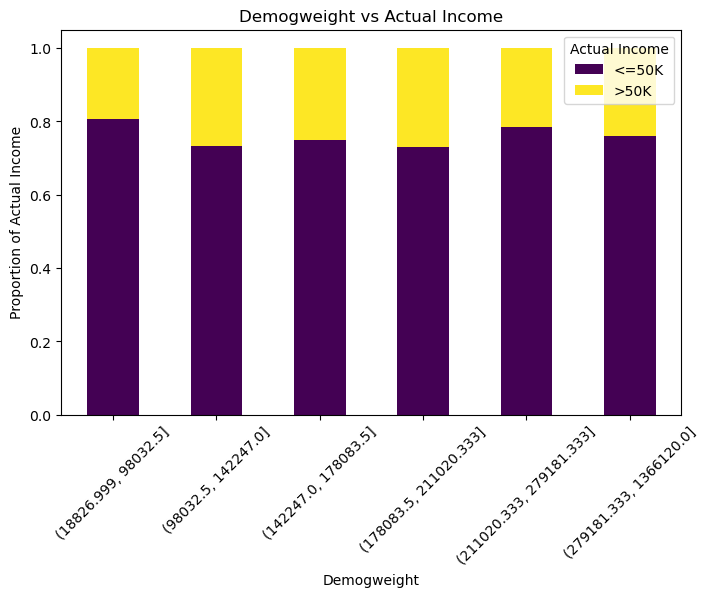

In [33]:
X_test_original['demogweight_bin'] = pd.qcut(X_test_original['demogweight'], q=6)
capital_crosstab = pd.crosstab(
    X_test_original['demogweight_bin'],
    X_test_original['actual_income'],
    normalize='index'
)


capital_crosstab.plot(kind='bar', stacked=True, figsize=(8,5), colormap='viridis')
plt.ylabel('Proportion of Actual Income')
plt.xlabel('Demogweight')
plt.title('Demogweight vs Actual Income')
plt.legend(title='Actual Income', labels=['<=50K', '>50K'])
plt.xticks(rotation=45)
plt.show()